In [1]:
import sys
import matplotlib.pyplot as plt
import mplfinance as mpl
import numpy as np
 
# Avoid AttributeError: module 'sqlalchemy' has no attribute 'orm'
import sqlalchemy.orm  # noqa: F401

sys.path.append("..")
from bitflyer_hft_bot.db.database import initialize_database
from bitflyer_hft_bot.db import crud
from backtest.visualize.ohlcv import ohlcv_plot
from backtest.utils.utils import get_ohlcv_df, get_predict_df, match_timestamp_for_ohlcv
from backtest.backtest_trade.richman_backtest import richman_backtest

In [2]:
symbol = "FX_BTC_JPY"

_, SessionLocal = initialize_database(uri="sqlite:///../example.db")
with SessionLocal() as db:
    ohlcv_data = crud.get_ohlcv_with_symbol(db=db, symbol=symbol)
    predict_data = crud.get_predict_items(db=db, symbol=symbol)

time_span = 5
ohlcv_df = get_ohlcv_df(ohlcv_data, time_span=time_span)
buy_df, sell_df = get_predict_df(predict_data)
timestamped_buy_df = match_timestamp_for_ohlcv(ohlcv_df, buy_df, time_span)
timestamped_sell_df = match_timestamp_for_ohlcv(ohlcv_df, sell_df, time_span)

result_online = richman_backtest(ohlcv_df.copy(), buy_df=timestamped_buy_df.shift(-1), sell_df=timestamped_sell_df.shift(-1))

In [3]:
ohlcv_df.describe()

,open,high,low,close,volume
count,3.115000e+03,3.115000e+03,3.115000e+03,3.115000e+03,3115.000000
mean,5.809896e+06,5.809950e+06,5.809831e+06,5.809894e+06,0.047627
std,3.995117e+03,4.076996e+03,3.906025e+03,3.989867e+03,0.225639
min,5.799235e+06,5.799235e+06,5.799014e+06,5.799033e+06,0.000000
25%,5.808975e+06,5.808975e+06,5.808975e+06,5.808975e+06,0.000000
50%,5.808975e+06,5.808975e+06,5.808975e+06,5.808975e+06,0.000000
75%,5.808975e+06,5.808975e+06,5.808975e+06,5.808975e+06,0.000000
max,5.844590e+06,5.845096e+06,5.842000e+06,5.843499e+06,5.370000


/Users/akiranoda/projects/bitflyer-websocket/.venv/lib/python3.9/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


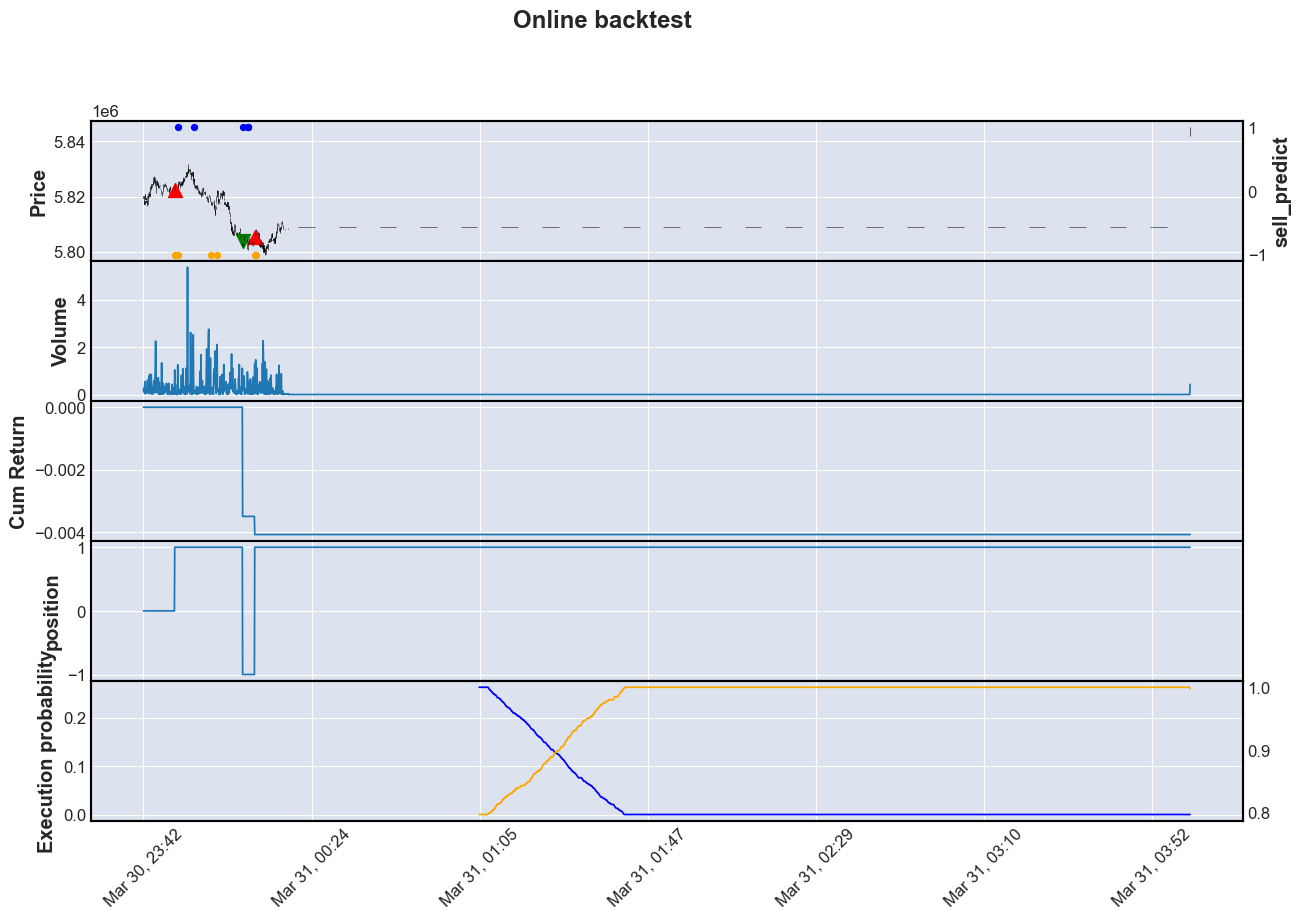

In [4]:
mpl_adds = [
    # Prediction plot
    mpl.make_addplot(np.where(timestamped_buy_df["is_entry"] == True, -1, np.nan), type="scatter", ylabel="buy_predict", color="orange", y_on_right=False),
    mpl.make_addplot(np.where(timestamped_sell_df["is_entry"] == True, 1, np.nan), type="scatter", ylabel="sell_predict", color="blue", y_on_right=False),

    # Entry plot
    mpl.make_addplot(result_online["buy_entry_price"] - 1000, type="scatter", markersize=100, marker="^", color="r"),
    mpl.make_addplot(result_online["sell_entry_price"] + 1000, type="scatter", markersize=100, marker="v", color="g"),

    # Volume plot
    mpl.make_addplot(ohlcv_df["volume"], type="line", panel=1, ylabel="Volume", y_on_right=False),

    # Cumulative plot
    mpl.make_addplot(result_online["cumulative_return"], type="line", panel=2, ylabel="Cum Return", y_on_right=False),

    # Position plot
    mpl.make_addplot(result_online["position"], type="line", panel=3, ylabel="position", y_on_right=False),

    # Execution plot
    mpl.make_addplot(result_online["buy_executed"].rolling(1000).mean(), type="line", panel=4, ylabel="Execution probability", color="blue", y_on_right=False),
    mpl.make_addplot(result_online["sell_executed"].rolling(1000).mean(), type="line", panel=4, color="orange", y_on_right=False),

]
fig, axes = mpl.plot(ohlcv_df, type="candle", addplot=mpl_adds, figsize=(16, 10), panel_ratios=(1,1), figratio=(1,1), figscale=1.5, title="Online backtest", returnfig=True)
plt.show()
plt.close()

In [5]:
# local data backtest
local_timestamped_buy_df = timestamped_buy_df.copy()
local_timestamped_sell_df = timestamped_sell_df.copy()
pips = 100
local_timestamped_buy_df['price'] = ohlcv_df.loc[:,'close'] - pips
local_timestamped_sell_df['price'] = ohlcv_df.loc[:,'close'] + pips
result_local = richman_backtest(ohlcv_df.copy(), buy_df=local_timestamped_buy_df.shift(-1), sell_df=local_timestamped_sell_df.shift(-1))

/Users/akiranoda/projects/bitflyer-websocket/.venv/lib/python3.9/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


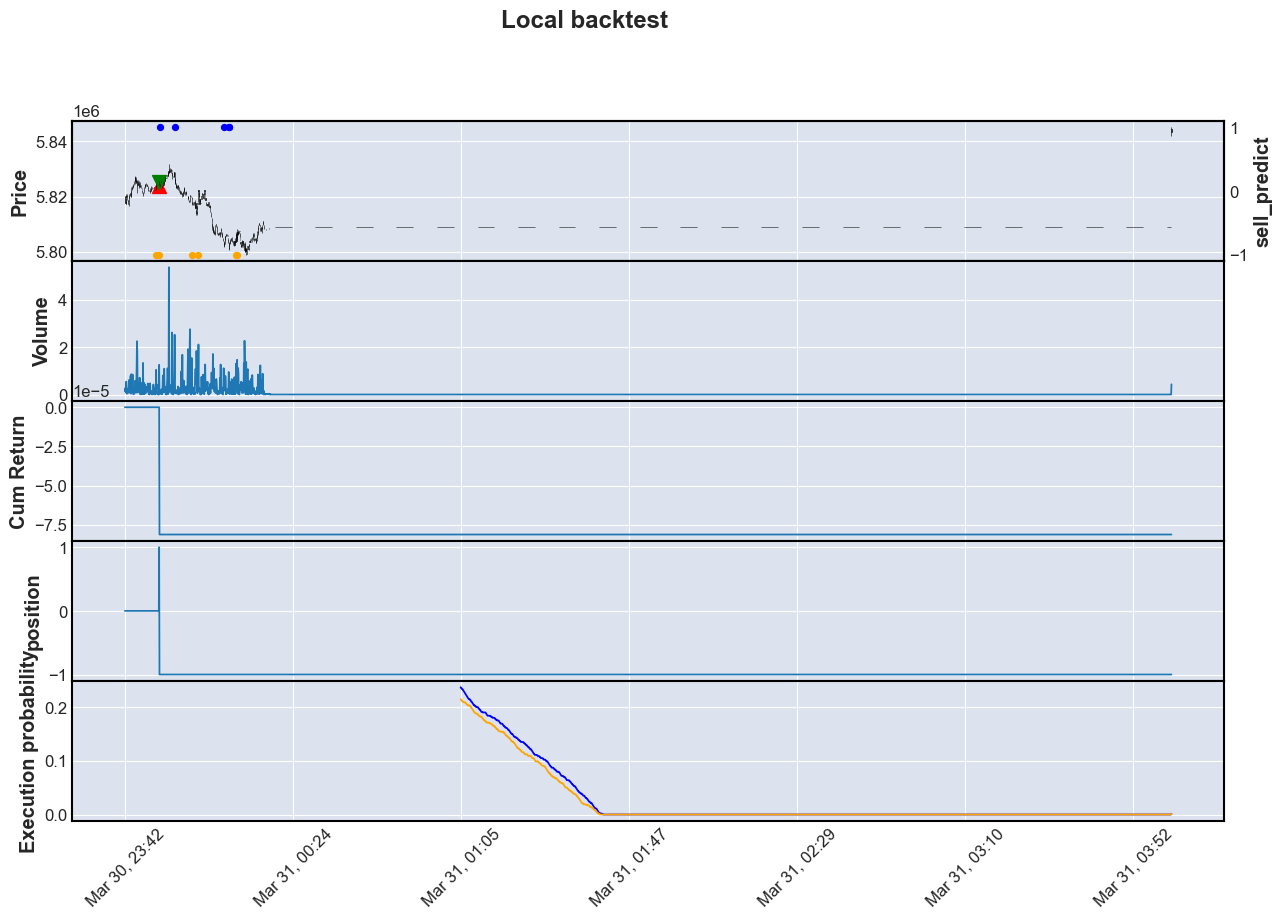

In [6]:
mpl_adds = [
    # Prediction plot
    mpl.make_addplot(np.where(timestamped_buy_df["is_entry"] == True, -1, np.nan), type="scatter", ylabel="buy_predict", color="orange", y_on_right=False),
    mpl.make_addplot(np.where(timestamped_sell_df["is_entry"] == True, 1, np.nan), type="scatter", ylabel="sell_predict", color="blue", y_on_right=False),

    # Entry plot
    mpl.make_addplot(result_local["buy_entry_price"] - 1000, type="scatter", markersize=100, marker="^", color="r"),
    mpl.make_addplot(result_local["sell_entry_price"] + 1000, type="scatter", markersize=100, marker="v", color="g"),

    # Volume plot
    mpl.make_addplot(ohlcv_df["volume"], type="line", panel=1, ylabel="Volume", y_on_right=False),

    # Cumulative plot
    mpl.make_addplot(result_local["cumulative_return"], type="line", panel=2, ylabel="Cum Return", y_on_right=False),

    # Position plot
    mpl.make_addplot(result_local["position"], type="line", panel=3, ylabel="position", y_on_right=False),

    # Execution plot
    mpl.make_addplot(result_local["buy_executed"].rolling(1000).mean(), type="line", panel=4, ylabel="Execution probability", color="blue", y_on_right=False),
    mpl.make_addplot(result_local["sell_executed"].rolling(1000).mean(), type="line", panel=4, color="orange", y_on_right=False),
]
mpl.plot(ohlcv_df, type="candle", addplot=mpl_adds, figsize=(16, 10), panel_ratios=(1,1), figratio=(1,1), figscale=1.5, title="Local backtest")
plt.close()

In [7]:

result_online.head(50)

,cumulative_return,position,buy_entry_price,sell_entry_price,buy_exit_price,sell_exit_price,buy_executed,sell_executed
timestamp,,,,,,,,
2022-03-30 23:42:30+00:00,0.0,0.0,NaN,NaN,NaN,NaN,False,True
2022-03-30 23:42:35+00:00,0.0,0.0,NaN,NaN,NaN,NaN,False,True
2022-03-30 23:42:40+00:00,0.0,0.0,NaN,NaN,NaN,NaN,False,True
2022-03-30 23:42:45+00:00,0.0,0.0,NaN,NaN,NaN,NaN,False,True
2022-03-30 23:42:50+00:00,0.0,0.0,NaN,NaN,NaN,NaN,False,True
2022-03-30 23:42:55+00:00,0.0,0.0,NaN,NaN,NaN,NaN,False,True
2022-03-30 23:43:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,False,True
2022-03-30 23:43:05+00:00,0.0,0.0,NaN,NaN,NaN,NaN,False,True
2022-03-30 23:43:10+00:00,0.0,0.0,NaN,NaN,NaN,NaN,False,True


In [8]:
ohlcv_df.describe()

,open,high,low,close,volume
count,3.115000e+03,3.115000e+03,3.115000e+03,3.115000e+03,3115.000000
mean,5.809896e+06,5.809950e+06,5.809831e+06,5.809894e+06,0.047627
std,3.995117e+03,4.076996e+03,3.906025e+03,3.989867e+03,0.225639
min,5.799235e+06,5.799235e+06,5.799014e+06,5.799033e+06,0.000000
25%,5.808975e+06,5.808975e+06,5.808975e+06,5.808975e+06,0.000000
50%,5.808975e+06,5.808975e+06,5.808975e+06,5.808975e+06,0.000000
75%,5.808975e+06,5.808975e+06,5.808975e+06,5.808975e+06,0.000000
max,5.844590e+06,5.845096e+06,5.842000e+06,5.843499e+06,5.370000


In [9]:
pips = 500
ohlcv_df["local_buy_price"] = ohlcv_df["close"] - pips
merged_buy_df = timestamped_buy_df.merge(ohlcv_df["local_buy_price"], right_index=True, left_index=True)
merged_buy_df["subt_online_local"] = merged_buy_df["price"] - merged_buy_df["local_buy_price"]
merged_buy_df[['price', "local_buy_price", "subt_online_local"]].tail(30)

,price,local_buy_price,subt_online_local
timestamp,,,
2022-03-31 03:59:35+00:00,5808845.0,5808475.0,370.0
2022-03-31 03:59:40+00:00,5808845.0,5808475.0,370.0
2022-03-31 03:59:45+00:00,5808845.0,5808475.0,370.0
2022-03-31 03:59:50+00:00,5808845.0,5808475.0,370.0
2022-03-31 03:59:55+00:00,5808845.0,5808475.0,370.0
2022-03-31 04:00:00+00:00,5808845.0,5808475.0,370.0
2022-03-31 04:00:05+00:00,5808845.0,5808475.0,370.0
2022-03-31 04:00:10+00:00,5808845.0,5808475.0,370.0
2022-03-31 04:00:15+00:00,5808845.0,5808475.0,370.0


In [10]:
ohlcv_df.head(20)

,open,high,low,close,volume,local_buy_price
timestamp,,,,,,
2022-03-30 23:42:30+00:00,5819515.0,5820286.0,5819515.0,5820286.0,0.150000,5819786.0
2022-03-30 23:42:35+00:00,5820286.0,5820286.0,5819175.0,5819703.0,0.270128,5819203.0
2022-03-30 23:42:40+00:00,5818954.0,5818954.0,5817399.0,5817667.0,0.125967,5817167.0
2022-03-30 23:42:45+00:00,5818250.0,5818371.0,5817400.0,5817400.0,0.080000,5816900.0
2022-03-30 23:42:50+00:00,5819122.0,5820938.0,5819122.0,5820938.0,0.542685,5820438.0
2022-03-30 23:42:55+00:00,5820347.0,5820986.0,5819829.0,5819970.0,0.159755,5819470.0
2022-03-30 23:43:00+00:00,5819383.0,5819383.0,5819165.0,5819165.0,0.030000,5818665.0
2022-03-30 23:43:05+00:00,5819613.0,5819613.0,5819165.0,5819599.0,0.070000,5819099.0
2022-03-30 23:43:10+00:00,5818807.0,5818854.0,5817986.0,5818854.0,0.223392,5818354.0


In [11]:
ohlcv_df["std_vol"] = ohlcv_df["volume"].rolling(10).std()
print(ohlcv_df["std_vol"][0])
ohlcv_df[50:].head(50)

nan


,open,high,low,close,volume,local_buy_price,std_vol
timestamp,,,,,,,
2022-03-30 23:46:40+00:00,5822932.0,5822932.0,5822581.0,5822581.0,0.043170,5822081.0,0.263205
2022-03-30 23:46:45+00:00,5822431.0,5822511.0,5821576.0,5821576.0,0.267690,5821076.0,0.250712
2022-03-30 23:46:50+00:00,5821576.0,5821576.0,5821400.0,5821576.0,0.020000,5821076.0,0.248814
2022-03-30 23:46:55+00:00,5821400.0,5821400.0,5820836.0,5820979.0,0.097469,5820479.0,0.248290
2022-03-30 23:47:00+00:00,5820342.0,5821822.0,5820158.0,5821238.0,1.333180,5820738.0,0.418183
2022-03-30 23:47:05+00:00,5820924.0,5820924.0,5820924.0,5820924.0,0.020000,5820424.0,0.418240
2022-03-30 23:47:10+00:00,5821291.0,5821628.0,5821291.0,5821628.0,0.020000,5821128.0,0.418240
2022-03-30 23:47:15+00:00,5821673.0,5823329.0,5821673.0,5823114.0,0.490000,5822614.0,0.416820
2022-03-30 23:47:20+00:00,5822926.0,5822926.0,5822926.0,5822926.0,0.020000,5822426.0,0.415629


In [12]:
std20 = ohlcv_df["close"].rolling(20).std()
ohlcv_df["bb_upper"] = (ohlcv_df["close"] + std20 * 2.0).rolling(5).mean()
ohlcv_df["bb_lower"] = (ohlcv_df["close"] - std20 * 2.0).rolling(5).mean()

ohlcv_df["std_vol"] = ohlcv_df["volume"].rolling(15).std()
ohlcv_df[90:].head(50)

,open,high,low,close,volume,local_buy_price,std_vol,bb_upper,bb_lower
timestamp,,,,,,,,,
2022-03-30 23:50:00+00:00,5823694.0,5823694.0,5823694.0,5823694.0,0.000000,5823194.0,0.105963,5.824302e+06,5.822023e+06
2022-03-30 23:50:05+00:00,5822646.0,5823422.0,5822349.0,5823422.0,0.290000,5822922.0,0.117253,5.824499e+06,5.822195e+06
2022-03-30 23:50:10+00:00,5822422.0,5822494.0,5822390.0,5822413.0,0.050000,5821913.0,0.117767,5.824520e+06,5.822141e+06
2022-03-30 23:50:15+00:00,5823493.0,5824562.0,5822494.0,5823080.0,1.040279,5822580.0,0.269937,5.824470e+06,5.822052e+06
2022-03-30 23:50:20+00:00,5822858.0,5823649.0,5822678.0,5822678.0,0.240000,5822178.0,0.269900,5.824253e+06,5.821862e+06
2022-03-30 23:50:25+00:00,5822678.0,5822678.0,5821890.0,5821892.0,0.419671,5821392.0,0.275041,5.823859e+06,5.821535e+06
2022-03-30 23:50:30+00:00,5822006.0,5822584.0,5822006.0,5822584.0,0.021000,5822084.0,0.274028,5.823662e+06,5.821397e+06
2022-03-30 23:50:35+00:00,5822793.0,5822793.0,5822793.0,5822793.0,0.011000,5822293.0,0.275699,5.823704e+06,5.821507e+06
2022-03-30 23:50:40+00:00,5822891.0,5822891.0,5821893.0,5821893.0,0.041000,5821393.0,0.274333,5.823457e+06,5.821279e+06


In [13]:
timestamped_buy_df[90:].head(50)

,side,price,size,predict_value,symbol,is_entry,acutual_timestamp
timestamp,,,,,,,
2022-03-30 23:50:00+00:00,BUY,5.823175e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:50:00.230000+00:00
2022-03-30 23:50:05+00:00,BUY,5.823038e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:50:05.018000+00:00
2022-03-30 23:50:10+00:00,BUY,5.822852e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:50:10.389000+00:00
2022-03-30 23:50:15+00:00,BUY,5.823053e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:50:15.190000+00:00
2022-03-30 23:50:20+00:00,BUY,5.823353e+06,0.01,1.0,FX_BTC_JPY,True,2022-03-30 23:50:20.040000+00:00
2022-03-30 23:50:25+00:00,BUY,5.823126e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:50:25.434000+00:00
2022-03-30 23:50:30+00:00,BUY,5.822350e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:50:30.319000+00:00
2022-03-30 23:50:35+00:00,BUY,5.822105e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:50:35.121000+00:00
2022-03-30 23:50:40+00:00,BUY,5.822396e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:50:40.469000+00:00


In [14]:
timestamped_sell_df[80:150].head(50)

,side,price,size,predict_value,symbol,is_entry,acutual_timestamp
timestamp,,,,,,,
2022-03-30 23:49:10+00:00,SELL,5.822633e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:49:10.036000+00:00
2022-03-30 23:49:15+00:00,SELL,5.822830e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:49:15.408000+00:00
2022-03-30 23:49:20+00:00,SELL,5.822976e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:49:20.158000+00:00
2022-03-30 23:49:25+00:00,SELL,5.822828e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:49:25.744000+00:00
2022-03-30 23:49:30+00:00,SELL,5.822641e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:49:30.120000+00:00
2022-03-30 23:49:35+00:00,SELL,5.822987e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:49:35.506000+00:00
2022-03-30 23:49:40+00:00,SELL,5.823490e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:49:40.292000+00:00
2022-03-30 23:49:45+00:00,SELL,5.823054e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:49:45.082000+00:00
2022-03-30 23:49:50+00:00,SELL,5.823005e+06,0.01,0.0,FX_BTC_JPY,False,2022-03-30 23:49:50.458000+00:00


In [15]:
result_online[80:].head(50)

,cumulative_return,position,buy_entry_price,sell_entry_price,buy_exit_price,sell_exit_price,buy_executed,sell_executed
timestamp,,,,,,,,
2022-03-30 23:49:10+00:00,0.0,0.0,NaN,NaN,NaN,NaN,False,True
2022-03-30 23:49:15+00:00,0.0,0.0,NaN,NaN,NaN,NaN,True,False
2022-03-30 23:49:20+00:00,0.0,0.0,NaN,NaN,NaN,NaN,True,False
2022-03-30 23:49:25+00:00,0.0,0.0,NaN,NaN,NaN,NaN,False,True
2022-03-30 23:49:30+00:00,0.0,0.0,NaN,NaN,NaN,NaN,False,True
2022-03-30 23:49:35+00:00,0.0,0.0,NaN,NaN,NaN,NaN,True,False
2022-03-30 23:49:40+00:00,0.0,0.0,NaN,NaN,NaN,NaN,True,False
2022-03-30 23:49:45+00:00,0.0,0.0,NaN,NaN,NaN,NaN,False,True
2022-03-30 23:49:50+00:00,0.0,0.0,NaN,NaN,NaN,NaN,False,True
